# **Chapter 6: Synchronization Tools – Practice Exercise Solutions**

## **6.1 Clock Interrupts and Disabling Interrupts**

**Question:**  
In Section 6.4, we mentioned that disabling interrupts frequently can affect the system’s clock. Explain why this can occur and how such effects can be minimized.

**Answer:**  
The system clock is updated at every **clock interrupt**. If interrupts are disabled—especially for extended periods—the system clock may lose accurate timekeeping because it misses these updates. Additionally, the scheduler relies on clock ticks to measure **time quanta** assigned to processes. At each clock interrupt, the scheduler checks if the currently running process’s time quantum has expired. If interrupts are disabled, scheduling accuracy degrades.

**Minimization:**  
Disable interrupts only for **very short periods**, ensuring the clock interrupt is not delayed significantly. Use higher-priority synchronization mechanisms (e.g., atomic instructions or spinlocks in multiprocessor systems) where possible instead of relying solely on interrupt disabling.


## **6.5 Binary Semaphore for Mutual Exclusion**

**Question:**  
Illustrate how a binary semaphore can be used to implement mutual exclusion among *n* processes.

**Answer:**  
Shared binary semaphore `mutex` initialized to 1.  
Each process `P_i` executes:

```c
do {
    wait(mutex);
    // Critical Section
    signal(mutex);
    // Remainder Section
} while (true);
```

**Explanation:**  
Only one process can pass `wait(mutex)` at a time because the semaphore acts as a lock. After exiting the critical section, `signal(mutex)` releases the lock.



## **Exercise 6.16**
**Question:**  
One approach for using compare and swap() for implementing a spinlock is as follows:
```
void lock_spinlock(int *lock) {
while (compare_and_swap(lock, 0, 1) != 0)
; /* spin */
}
```
A suggested alternative approach is to use the “compare and compare-and-swap” idiom, which checks the status of the lock before invoking the compare and swap() operation. (The rationale behind this approach is to invoke compare and swap() only if the lock is currently available.) This strategy is shown below:
```
void lock_spinlock(int *lock) {
while (true) {
if (*lock == 0) {
/* lock appears to be available */
if (!compare_and_swap(lock, 0, 1))
break;
}
}
}
```
Does this “compare and compare-and-swap” idiom work appropriately for implementing spinlocks? If so, explain. If not, illustrate how the integrity of the lock is compromised.

**Answer:**  
No, the "compare and compare-and-swap" idiom **does not work appropriately** for implementing spinlocks in a concurrent environment. It compromises the integrity of the lock by allowing **multiple threads to potentially acquire the lock simultaneously**, violating mutual exclusion.

**How integrity is compromised:**  
Between the check `if (*lock == 0)` and the subsequent `compare_and_swap(lock, 0, 1)`, another thread can modify `*lock`. For example:
1. Thread A checks `*lock`, finds it 0 (available).
2. Before Thread A executes its CAS, Thread B also checks `*lock`, finds it 0, and successfully performs a CAS, setting `*lock` to 1 and acquiring the lock.
3. Thread A now proceeds to its CAS: it expects `*lock` to be 0 (but it's now 1), so the CAS fails (returns a non-zero value). However, because the code uses `if (!compare_and_swap(...))` (i.e., breaks only if CAS returns 0/false), the CAS failure means it does **not** break out of the loop. Instead, it continues spinning.
4. Thread B releases the lock (sets `*lock` back to 0).
5. Thread A, still in its loop, will again see `*lock == 0` in the next iteration, and may now successfully CAS, acquiring the lock.
6. Meanwhile, another Thread C could also see the lock as 0 and compete.


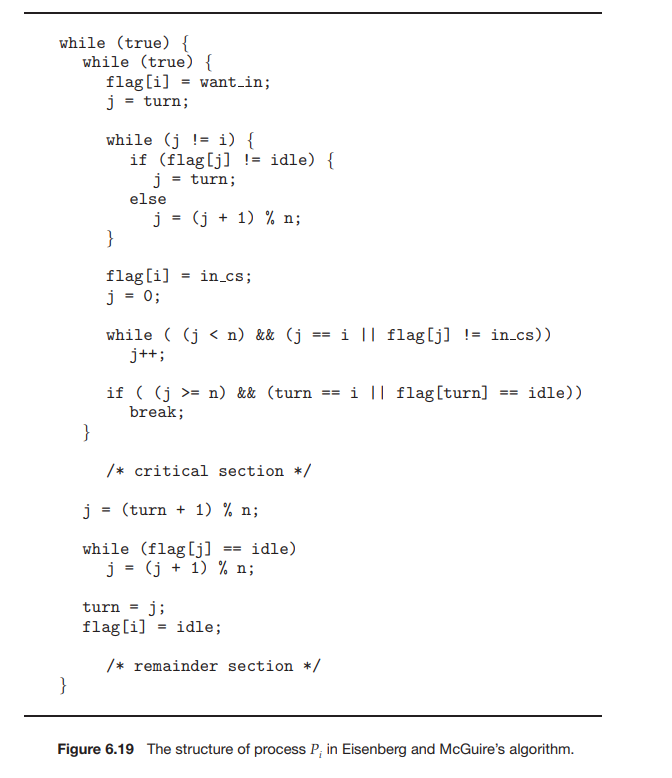


## **Exercise 6.19**
**Question:**  
The first known correct software solution to the critical-section problem for n processes with a lower bound on waiting of n − 1 turns was presented by Eisenberg and McGuire. The processes share the following variables:
```
enum pstate {idle, want_in, in_cs};
pstate flag[n];
int turn;
```
All the elements of flag are initially idle. The initial value of turn is immaterial (between 0 and n-1). The structure of process Pi is shown in Figure 6.19. Prove that the algorithm satisfies all three requirements for the critical-section problem.




**Answer:**  
**Eisenberg and McGuire's Algorithm Proof:**  
The algorithm uses a rotating priority mechanism.

**1. Mutual Exclusion:**  
- A process Pi enters the critical section only when it has set `flag[i] = in_cs` and verified that no other process is in `in_cs` state (`while ((j < n) && (j == i || flag[j] != in_cs))` ensures all other `flag[j]` are not `in_cs`). Also, it ensures that either it is its turn (`turn == i`) or the current `turn` process is idle. This guarantees that only one process can be in the `in_cs` state at a time.

**2. Progress:**  
- If no process is in CS and some processes want to enter, the `turn` variable and the scanning loop ensure that one will eventually pass the conditions. The algorithm avoids deadlock because processes waiting will repeatedly scan; the `turn` variable rotates, giving each process a chance. A process unable to enter will eventually see `turn == i` or `flag[turn] == idle` and break into CS.

**3. Bounded Waiting:**  
- The waiting bound is n-1 turns. After a process Pi exits the CS, it updates `turn` to the next process with `flag[j] != idle` in cyclic order. This ensures that processes wanting to enter are served in a round-robin fashion relative to the `turn` pointer. A process Pi will wait while at most n-1 other processes enter the CS before it, because `turn` will eventually point to Pi after serving others in the waiting set.

Thus, the algorithm satisfies mutual exclusion, progress, and bounded waiting for n processes.




## **Exercise 6.24**
**Question:**  
Assume that a system has multiple processing cores. For each of the following scenarios, describe which is a better locking mechanism—a spinlock or a mutex lock where waiting processes sleep while waiting for the lock to become available:
- The lock is to be held for a short duration.
- The lock is to be held for a long duration.
- A thread may be put to sleep while holding the lock.

**Answer:**  
- **Short duration:** **Spinlock** is better. The overhead of putting a thread to sleep and waking it (context switch) is likely higher than the time spent spinning if the lock is released quickly. On multicore systems, spinning avoids context-switch cost.
- **Long duration:** **Mutex lock (sleep/wakeup)** is better. Spinning for a long time wastes CPU cycles that could be used by other threads. Blocking frees the CPU.
- **Thread may be put to sleep while holding the lock:** **Mutex lock (sleep/wakeup)** is **required**. If a thread holding a spinlock sleeps (blocks), other threads spinning for the lock will waste CPU indefinitely because the holder cannot release it. A mutex lock that supports sleeping holders typically uses mechanisms like **priority inheritance** or **avoidance of sleep while holding**, but the lock implementation must allow the holder to sleep without deadlock.

---

## **Exercise 6.26**
**Question:**  
A multithreaded web server wishes to keep track of the number of requests it services (known as hits). Consider the two following strategies to prevent a race condition on the variable hits. The first strategy is to use a basic mutex lock when updating hits:
```
int hits;
mutex_lock hit_lock;

hit_lock.acquire();
hits++;
hit_lock.release();
```
A second strategy is to use an atomic integer:
```
atomic_t hits;
atomic_inc(&hits);
```
Explain which of these two strategies is more efficient.

**Answer:**  
The **atomic integer** strategy is more efficient.  
Reason:  
- **Mutex lock** involves the overhead of acquiring/releasing a lock (which may involve system calls, context switches if contended, or at least atomic operations plus spinning/blocking). Even with low contention, lock overhead is significant for a simple increment.  
- **Atomic integer increment** uses a hardware atomic instruction (like `fetch_and_add` or `compare_and_swap`) directly on the shared variable. This is typically implemented as a single CPU instruction or a short lock-free sequence, avoiding lock management overhead and reducing contention latency. Atomic operations are designed for fine-grained updates like counters.

Thus, for a simple counter increment, an atomic integer is faster and scales better with many threads.

--- 

**End of Chapter 6 Exercises (Complete)**

## **Exercise 6.27**



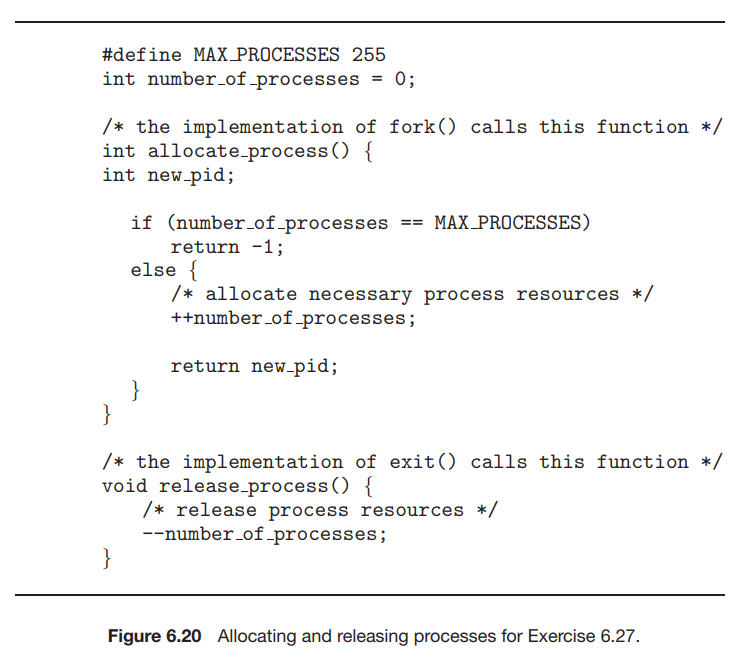



**Question:**  
Consider the code example for allocating and releasing processes shown in Figure 6.20.

a. Identify the race condition(s).

b. Assume you have a mutex lock named mutex with the operations acquire() and release(). Indicate where the locking needs to be placed to prevent the race condition(s).

c. Could we replace the integer variable `int number_of_processes = 0` with the atomic integer `atomic_t number_of_processes = 0` to prevent the race condition(s)?

**Answer:**  
**a.** Race conditions occur on the shared variable `number_of_processes`:
   - Between the check `if (number_of_processes == MAX_PROCESSES)` and the increment `++number_of_processes` in `allocate_process()`.
   - Between the decrement `--number_of_processes` and any concurrent read/increment/decrement in `release_process()` and `allocate_process()`.
   Example: Two concurrent calls to `allocate_process()` could both pass the check before either increments, causing `number_of_processes` to exceed `MAX_PROCESSES`.

**b.** Locking placement:
```c
int allocate_process() {
    int new_pid;
    acquire(mutex);
    if (number_of_processes == MAX_PROCESSES) {
        release(mutex);
        return -1;
    }
    else {
        /* allocate process resources */
        ++number_of_processes;
        release(mutex);
        return new_pid;
    }
}

void release_process() {
    acquire(mutex);
    /* release process resources */
    --number_of_processes;
    release(mutex);
}
```
The lock must be held during the entire read-modify-write sequence.

**c.** Yes, replacing `int number_of_processes` with an **atomic integer** `atomic_t number_of_processes` could prevent the race condition **if** the atomic type provides operations like `atomic_compare_and_swap()` or `atomic_fetch_and_add()` that allow us to perform the check-and-increment atomically. For example:
```c
int allocate_process() {
    int old_count;
    do {
        old_count = atomic_read(&number_of_processes);
        if (old_count == MAX_PROCESSES)
            return -1;
    } while (!atomic_compare_and_swap(&number_of_processes, old_count, old_count + 1));
    /* allocate resources */
    return new_pid;
}
```
Atomic operations avoid lock overhead but require careful implementation to ensure the entire allocation logic is race-free (including resource allocation). The simple increment/decrement can be made atomic, but the resource allocation part might still need separate protection.

---



## **Exercise 6.30**
**Question:**  
Demonstrate that monitors and semaphores are equivalent to the degree that they can be used to implement solutions to the same types of synchronization problems.

**Answer:**  
**Monitors** are high-level synchronization constructs that provide mutual exclusion and condition variables for waiting/signaling. **Semaphores** are lower-level integer variables with atomic `wait()` and `signal()` operations.  
To show equivalence, we must show that one can implement the other:

1. **Implementing a Monitor using Semaphores:**
   - Mutual exclusion: Use a binary semaphore `mutex` (initialized to 1) to ensure only one process enters the monitor.
   - Condition variables: For each condition `cond`, use a semaphore `cond_sem` (initialized to 0) and an integer `cond_count` (count of processes waiting on `cond`).
   - `cond.wait()`: `cond_count++`; `signal(mutex)` (release monitor lock); `wait(cond_sem)`; `wait(mutex)` (reacquire lock upon waking).
   - `cond.signal()`: if `cond_count > 0`, then `cond_count--`; `signal(cond_sem)`.

2. **Implementing Semaphores using a Monitor:**
   - Create a monitor with a shared integer `value` and a condition variable `cond`.
   - `wait()`: `while (value <= 0) cond.wait(); value--;`
   - `signal()`: `value++; cond.signal();`

Since each can simulate the other, they are **equivalent in expressive power** for solving synchronization problems (like mutual exclusion, producer-consumer, reader-writer). The difference is in ease of use and risk of programmer error (monitors are safer).

---

## **Exercise 6.32**
**Question:**  
Suppose the `signal()` statement can appear only as the last statement in a monitor function. Suggest how the implementation described in Section 6.7 can be simplified in this situation.

**Answer:**  
If `signal()` is always the last statement, then after signaling, the signaling process immediately exits the monitor. This simplifies the implementation because:
- There is **no need to decide** between continuing or yielding to the signaled process (as in Hoare vs. Mesa semantics). The signaler is done.
- The signaled process can be scheduled to run after the signaler exits, automatically acquiring the monitor lock.
- Implementation can treat `signal()` as: wake up one waiting process (if any), then exit the monitor and release mutual exclusion. The awakened process will acquire the lock when it resumes.

This eliminates complexities like **urgent queues** or temporary blocking of the signaler.

---

## **Exercise 6.33**
**Question:**  
Consider a system consisting of processes P1, P2, ..., Pn, each of which has a unique priority number. Write a monitor that allocates three identical printers to these processes, using the priority numbers for deciding the order of allocation.

**Answer:**  
Assume lower priority number = higher priority (e.g., 1 is highest).  
Monitor with:
- Integer `available_printers = 3`.
- Condition variable `printer_available`.
- Each process calls `request_printer(priority)` and `release_printer()`.

```java
monitor PrinterAllocator {
    int available = 3;
    condition printer_available;

    void request_printer(int priority) {
        while (available == 0) {
            // Wait, but priority scheduling needed.
            // To enforce priority order, we could maintain a priority queue of waiting processes.
            // Simpler: use FIFO and rely on external scheduler, but problem asks priority-based.
            // We'll assume condition variables support priority ordering (e.g., by priority number).
            printer_available.wait(priority); // hypothetical wait with priority parameter
        }
        available--;
    }

    void release_printer() {
        available++;
        printer_available.signal(); // wake highest priority waiter if supported
    }
}
```
In practice, monitors with pure condition variables may not support priority ordering directly. An alternative: maintain a **priority queue** inside the monitor using an array or list of condition variables per priority. Simpler: use a single condition variable and loop, but allocation may not be strictly priority-ordered if multiple waiters awaken.

---

## **Exercise 6.34**
**Question:**  
A file is to be shared among different processes, each of which has a unique number. The file can be accessed simultaneously by several processes, subject to the following constraint: the sum of all unique numbers associated with all the processes currently accessing the file must be less than n. Write a monitor to coordinate access to the file.

**Answer:**  
Monitor with:
- Integer `current_sum = 0`.
- Integer `limit = n` (given).
- Condition variable `safe_to_enter`.

```java
monitor FileAccess {
    int current_sum = 0;
    int limit = n; // given n
    condition safe;

    void request_access(int unique_num) {
        while (current_sum + unique_num >= limit) {
            safe.wait();
        }
        current_sum += unique_num;
        // enter file
    }

    void release_access(int unique_num) {
        current_sum -= unique_num;
        safe.signal_all(); // or signal() to wake one at a time
    }
}
```
Note: `signal_all()` (broadcast) is used because releasing may allow multiple waiting processes to proceed (since sum decreases). A single `signal()` might only wake one process, which might still find the sum too high, leading to deadlock. Broadcasting ensures all waiting processes recheck the condition.

---

## **Exercise 6.35**
**Question:**  
When a signal is performed on a condition inside a monitor, the signaling process can either continue its execution or transfer control to the process that is signaled. How would the solution to the preceding exercise differ with these two different ways in which signaling can be performed?

**Answer:**  
**Preceding exercise**: File access monitor with sum constraint.

- **Hoare semantics (transfer control)**:  
  When a process calls `release_access()` and signals, the signaled process (the one with highest priority or first in queue) runs immediately, before the signaler continues. This ensures the awakened process gets the lock **immediately** and can check the condition `current_sum + unique_num < limit` while the sum is guaranteed to be low (since signaler hasn't altered `current_sum` further). This reduces **spurious wake-ups** (waiting processes recheck condition and find it still false). Implementation may be simpler because condition checks are more predictable.

- **Mesa semantics (signaler continues)**:  
  The signaler continues and exits the monitor, releasing the lock. The signaled process is moved to the ready queue but may not run immediately; another process could enter the monitor before it, possibly changing `current_sum`. Thus, when the signaled process finally runs, the condition `current_sum + unique_num < limit` may no longer hold, so it must recheck in a **while loop** (as written). This requires **broadcast (`signal_all()`)** to avoid missing possible opportunities, because a single `signal()` might wake a process that cannot proceed, while others could.

**Difference**: Hoare semantics allow simpler `if` condition checks and possibly `signal()` instead of `broadcast`. Mesa semantics require **while loops** and often `broadcast` for correctness, increasing overhead.

---

## **Exercise 6.36**
**Question:**  
Design an algorithm for a monitor that implements an alarm clock that enables a calling program to delay itself for a specified number of time units (ticks). You may assume the existence of a real hardware clock that invokes a function `tick()` in your monitor at regular intervals.

**Answer:**  
Monitor with:
- Integer `current_time = 0`.
- Condition variable `alarm`.
- A queue of (wakeup_time, process) pairs.

```java
monitor AlarmClock {
    int current_time = 0;
    condition alarm;
    struct WaitEntry { int wake_time; condition cond; }
    PriorityQueue<WaitEntry> queue; // sorted by wake_time

    void delay(int ticks) {
        int wake_time = current_time + ticks;
        WaitEntry we = new WaitEntry(wake_time, alarm);
        queue.insert(we);
        while (current_time < wake_time) {
            we.cond.wait();
        }
        queue.remove(we);
    }

    void tick() {
        current_time++;
        // Wake all processes whose wake_time <= current_time
        while (!queue.isEmpty() && queue.peek().wake_time <= current_time) {
            WaitEntry we = queue.pop();
            we.cond.signal();
        }
    }
}
```
- `delay(ticks)` causes the calling process to wait on a condition variable until `current_time` reaches its wakeup time.
- `tick()` increments time and signals all processes whose alarm time has arrived.
- Each process uses a separate condition variable (or a shared one with broadcast) to avoid unnecessary wake-ups.


## **7.2 Slim Reader-Writer Locks in Windows**

**Question:**  
Windows provides a lightweight synchronization tool called slim reader–writer locks. Whereas most implementations of reader–writer locks favor either readers or writers, or perhaps order waiting threads using a FIFO policy, slim reader–writer locks favor neither readers nor writers, nor are waiting threads ordered in a FIFO queue. Explain the benefits of providing such a synchronization tool.

**Answer:**  
**Simplicity and speed**. Slim reader-writer locks avoid the overhead of fairness policies (like FIFO ordering) or favoring readers/writers, which require additional queue management and state tracking. This makes acquisition and release **faster** with lower memory overhead. They are appropriate when strict fairness is not required, but fast, lightweight read-write synchronization is needed—common in high-performance kernel or user-space code where lock contention is moderate.




## **Exercise 7.12**
**Question:**  
Describe two kernel data structures in which race conditions are possible. Be sure to include a description of how a race condition can occur.

**Answer:**  
1. **Process/Thread Control Block (PCB/TCB) Linked List**  
   - **Race Condition**: When a new process is created or terminated, the kernel must update the linked list of PCBs. If two CPUs simultaneously attempt to insert or remove a PCB (e.g., during `fork()` and `exit()`), they may both manipulate the `next` pointers concurrently, corrupting the list. For example, both might read the same head pointer, then update it to point to their own new PCB, causing one insertion to be lost or creating a loop.

2. **Memory Allocation Buddy System Free List**  
   - **Race Condition**: The buddy system maintains lists of free memory blocks of different sizes. When allocating or freeing a block, the kernel must remove or insert blocks from these lists. If two processes on different cores simultaneously request memory of the same size, they might both find the same free block in the list, both attempt to remove it, and both believe they have acquired it, leading to double allocation and potential memory corruption.

---



## **Exercise 7.14**
**Question:**  
Design an algorithm for a bounded-buffer monitor in which the buffers (portions) are embedded within the monitor itself.

**Answer:**  
Monitor with internal buffer array and condition variables for empty/full.

```java
monitor BoundedBuffer {
    private int buffer[N];
    private int count = 0, in = 0, out = 0;
    condition notFull, notEmpty;

    void produce(int item) {
        while (count == N) {
            notFull.wait();  // wait until buffer not full
        }
        buffer[in] = item;
        in = (in + 1) % N;
        count++;
        notEmpty.signal();  // signal consumer
    }

    int consume() {
        while (count == 0) {
            notEmpty.wait(); // wait until buffer not empty
        }
        int item = buffer[out];
        out = (out + 1) % N;
        count--;
        notFull.signal();   // signal producer
        return item;
    }
}
```

---

## **Exercise 7.15**
**Question:**  
The strict mutual exclusion within a monitor makes the bounded-buffer monitor of Exercise 7.14 mainly suitable for small portions.
a. Explain why this is true.
b. Design a new scheme that is suitable for larger portions.

**Answer:**  
**a.** Strict mutual exclusion means only one thread can be active inside the monitor at a time. If the buffer operations (`produce`/`consume`) involve **large data portions** (e.g., copying large chunks of memory), the critical section becomes long. This serializes all producers and consumers, hurting **throughput** and **parallelism** unnecessarily, since multiple producers could fill different buffer slots concurrently, and multiple consumers could take from different slots concurrently.

**b.** **Scheme for larger portions**: Use a **reader-writer** style approach or **fine-grained locking**.
- Split the buffer into **multiple slots**, each with its own lock (or use an array of semaphores).
- Producers and consumers can operate on **different slots simultaneously**.
- Maintain shared counters (`count`, `in`, `out`) with atomic operations or a separate lock.

**Pseudocode using multiple semaphores:**
```c
semaphore mutex = 1;          // protects in/out/count
semaphore empty = N;          // counts empty slots
semaphore full = 0;           // counts full slots
semaphore slot_locks[N] = {1,1,...}; // one per slot

void produce(int item, int slot_index) {
    wait(empty);              // ensure space
    wait(mutex);
    // find free slot (could be predefined), e.g., slot_index = in;
    wait(slot_locks[slot_index]); // lock this slot only
    buffer[slot_index] = item; // copy large data
    update in, count;
    signal(mutex);
    signal(slot_locks[slot_index]);
    signal(full);
}

int consume(int slot_index) {
    wait(full);
    wait(mutex);
    // find full slot, e.g., slot_index = out;
    wait(slot_locks[slot_index]);
    int item = buffer[slot_index];
    update out, count;
    signal(mutex);
    signal(slot_locks[slot_index]);
    signal(empty);
    return item;
}
```
This allows concurrent data copying into different buffer slots.

---

## **Exercise 7.16**
**Question:**  
Discuss the tradeoff between fairness and throughput of operations in the readers–writers problem. Propose a method for solving the readers–writers problem without causing starvation.

**Answer:**  
**Tradeoff**:  
- **Throughput favor (Reader priority)**: Allows multiple readers simultaneously, maximizing read throughput, but **writers may starve** if readers keep arriving.  
- **Fairness (Writer priority or FIFO)**: Writers get timely access, preventing starvation, but may reduce read throughput because readers are serialized or forced to wait.  

**Starvation-Free Solution**:  
Use a **fair scheduling policy** like:
1. **Timestamp ordering**: Arriving threads (readers/writers) get a timestamp. Service in order; a writer blocks all later arrivals; a reader allows other readers with earlier timestamps to join.
2. **The "No Starvation" Readers-Writers Lock**:  
   - Use two mutexes: `resource_mutex` (for writers) and `read_count_mutex` (for reader count).  
   - Add a **turnstile** semaphore or a **queue semaphore** to enforce FIFO order for both readers and writers.  
   - When a writer is waiting, new readers are blocked until the writer finishes.  
   - Implementation often uses a **fair semaphore** (like `pthread_rwlock` with priority to writers) or **condition variables with a queue**.

**Example using condition variables:**
```java
monitor FairRW {
    int readers = 0;
    bool writing = false;
    int waitingWriters = 0;
    condition okToRead, okToWrite;

    void startRead() {
        while (writing || waitingWriters > 0) {
            okToRead.wait();
        }
        readers++;
        okToRead.signal(); // cascade to other waiting readers
    }

    void endRead() {
        readers--;
        if (readers == 0) {
            okToWrite.signal();
        }
    }

    void startWrite() {
        waitingWriters++;
        while (readers > 0 || writing) {
            okToWrite.wait();
        }
        waitingWriters--;
        writing = true;
    }

    void endWrite() {
        writing = false;
        if (waitingWriters > 0) {
            okToWrite.signal();
        } else {
            okToRead.signal();
        }
    }
}
```
This gives writers priority but ensures readers eventually proceed.


## **Exercise 7.18**
**Question:**  
Explain the difference between software and hardware transactional memory.

**Answer:**  
- **Software Transactional Memory (STM)**: Implemented entirely in software (libraries, compiler support). It uses **logging**, **versioning**, or **copy-on-write** to group memory operations into atomic transactions. Conflicts are detected via software algorithms (e.g., using locks or timestamps). Higher overhead but portable across hardware.

- **Hardware Transactional Memory (HTM)**: Supported directly by CPU hardware (e.g., Intel TSX, IBM POWER). Uses **cache coherence protocols** to detect conflicts and CPU caches to buffer speculative writes. Transactions are executed speculatively; if a conflict occurs (another core accesses same memory), hardware aborts and rolls back. Lower overhead, faster for small transactions, but limited by hardware constraints (cache size, instruction support).

**Key difference**: HTM is faster and transparent to programmer but limited in transaction size and not universally available. STM is more flexible (larger transactions) but slower due to software overhead.

--- 

**End of Chapter 7 Exercises**